In [1]:
import warnings
warnings.filterwarnings(
    "ignore",
    message="Palette images with Transparency expressed in bytes should be converted to RGBA images"
)

Подавляем шумное предупреждение PIL про palette transparency, потому что изображения приводим к RGB

In [2]:
from pathlib import Path
from collections import Counter
import numpy as np

IMAGES_DIR = Path("stardew_valley_pictures_5th_lab/dataset/images")

exts = {".png", ".jpg", ".jpeg", ".webp"}
files = [p for p in IMAGES_DIR.rglob("*") if p.is_file() and p.suffix.lower() in exts]
if not files:
    raise RuntimeError(f"no images in {IMAGES_DIR.resolve()}")

def label(p: Path) -> int:
    top = p.relative_to(IMAGES_DIR).parts[0]
    return 1 if top == "characters" else 0

y = [label(p) for p in files]
y = np.array([label(p) for p in files], dtype=np.int64)

folders = Counter([p.relative_to(IMAGES_DIR).parts[0] for p in files])
classes = Counter(y)

print("total:", len(files))
print("folder:", dict(folders))
print("binary:", dict(classes))

total: 1569
folder: {'mobs': 112, 'plants': 460, 'weapons': 74, 'characters': 861, 'fish': 62}
binary: {np.int64(0): 708, np.int64(1): 861}


Разметку вручную/LLM не делаем, потому что классы уже заданы папками датасета. Для задачи binary classification считаем characters положительным классом, все остальные - отрицательным. Проверили количество изображений в каждом классе.

In [3]:
root = IMAGES_DIR
files_np = np.array(files, dtype=object)

idx0 = np.where(y == 0)[0]
idx1 = np.where(y == 1)[0]
np.random.shuffle(idx0)
np.random.shuffle(idx1)

def split_idx(idx, train=0.7, val=0.15):
    n = len(idx)
    n_tr = int(n * train)
    n_va = int(n * val)
    return idx[:n_tr], idx[n_tr:n_tr+n_va], idx[n_tr+n_va:]

tr0, va0, te0 = split_idx(idx0)
tr1, va1, te1 = split_idx(idx1)

train_idx = np.concatenate([tr0, tr1])
val_idx   = np.concatenate([va0, va1])
test_idx  = np.concatenate([te0, te1])

np.random.shuffle(train_idx)
np.random.shuffle(val_idx)
np.random.shuffle(test_idx)

def info(name, idx):
    ys = y[idx]
    print(name, len(idx), "pos:", int(ys.sum()), "neg:", int((ys == 0).sum()))

info("train:", train_idx)
info("val:  ", val_idx)
info("test: ", test_idx)

train: 1097 pos: 602 neg: 495
val:   235 pos: 129 neg: 106
test:  237 pos: 130 neg: 107


In [4]:
train_set = set(files_np[train_idx])
val_set = set(files_np[val_idx])
test_set = set(files_np[test_idx])

print("train∩val:", len(train_set & val_set))
print("train∩test:", len(train_set & test_set))
print("val∩test:", len(val_set & test_set))

train∩val: 0
train∩test: 0
val∩test: 0


Пересечений между train/val/test нет, те нет утечки данных

In [5]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

class BinImgDS(Dataset):
    def __init__(self, paths, labels, tfm):
        self.paths = paths
        self.labels = labels
        self.tfm = tfm

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, i):
        img = Image.open(self.paths[i]).convert("RGB")
        img = self.tfm(img)
        yv = torch.tensor(self.labels[i], dtype=torch.float32)
        return img, yv

img_size = 96

train_tfm = transforms.Compose([
    transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.15, 0.15, 0.15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])

eval_tfm = transforms.Compose([
    transforms.Resize(img_size + 16),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])

train_ds = BinImgDS(files_np[train_idx].tolist(), y[train_idx].tolist(), train_tfm)
val_ds   = BinImgDS(files_np[val_idx].tolist(),   y[val_idx].tolist(),   eval_tfm)
test_ds  = BinImgDS(files_np[test_idx].tolist(),  y[test_idx].tolist(),  eval_tfm)

batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=0)
val_dl   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=0)
test_dl  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=0)

In [6]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.body = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
        )

    def forward(self, x):
        return self.body(x).squeeze(1)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNN().to(device)

crit = nn.BCEWithLogitsLoss()
opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-3)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", patience=2, factor=0.5)

с регуляризацией, чтобы не переобучаться на сравнительно небольшом датасете

In [7]:
@torch.no_grad()
def acc_from_logits(logits, yb):
    p = (torch.sigmoid(logits) >= 0.5).float()
    return (p == yb).float().mean().item()

def run_epoch(dl, train):
    if train:
        model.train()
    else:
        model.eval()

    loss_sum, acc_sum, n = 0.0, 0.0, 0

    for xb, yb in dl:
        xb = xb.to(device)
        yb = yb.to(device)

        if train:
            opt.zero_grad(set_to_none=True)

        logits = model(xb)
        loss = crit(logits, yb)

        if train:
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

        bs = xb.size(0)
        loss_sum += loss.item() * bs
        acc_sum += acc_from_logits(logits, yb) * bs
        n += bs

    return loss_sum / n, acc_sum / n

In [8]:
@torch.no_grad()
def acc_from_logits(logits, yb):
    p = (torch.sigmoid(logits) >= 0.5).float()
    return (p == yb).float().mean().item()

def run_epoch(dl, train):
    if train:
        model.train()
    else:
        model.eval()

    loss_sum, acc_sum, n = 0.0, 0.0, 0

    for xb, yb in dl:
        xb = xb.to(device)
        yb = yb.to(device)

        if train:
            opt.zero_grad(set_to_none=True)

        logits = model(xb)
        loss = crit(logits, yb)

        if train:
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

        bs = xb.size(0)
        loss_sum += loss.item() * bs
        acc_sum += acc_from_logits(logits, yb) * bs
        n += bs

    return loss_sum / n, acc_sum / n

In [9]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

run_name = datetime.now().strftime("cnn_%Y%m%d_%H%M%S")
writer = SummaryWriter(log_dir=f"runs/{run_name}")

hist = {"tr_loss": [], "va_loss": [], "tr_acc": [], "va_acc": []}

best_val = float("inf")
bad = 0
patience = 6
best_path = f"best_{run_name}.pt"

epochs = 20

for ep in range(1, epochs + 1):
    tr_loss, tr_acc = run_epoch(train_dl, True)
    va_loss, va_acc = run_epoch(val_dl, False)

    sch.step(va_loss)

    hist["tr_loss"].append(tr_loss)
    hist["va_loss"].append(va_loss)
    hist["tr_acc"].append(tr_acc)
    hist["va_acc"].append(va_acc)

    writer.add_scalar("loss/train", tr_loss, ep)
    writer.add_scalar("loss/val",   va_loss, ep)
    writer.add_scalar("acc/train",  tr_acc,  ep)
    writer.add_scalar("acc/val",    va_acc,  ep)
    writer.add_scalar("lr", opt.param_groups[0]["lr"], ep)

    print(f"ep {ep:02d} | tr {tr_loss:.4f}/{tr_acc:.4f} | va {va_loss:.4f}/{va_acc:.4f}")

    if va_loss < best_val - 1e-4:
        best_val = va_loss
        bad = 0
        torch.save(model.state_dict(), best_path)
    else:
        bad += 1
        if bad >= patience:
            print("early stop")
            break

writer.close()

print("run:", f"runs/{run_name}")
print("best:", best_path)

ep 01 | tr 0.3971/0.8049 | va 0.8131/0.4511
ep 02 | tr 0.2619/0.9079 | va 0.5579/0.6553
ep 03 | tr 0.2141/0.9316 | va 0.3932/0.8213
ep 04 | tr 0.2060/0.9271 | va 0.2552/0.9149
ep 05 | tr 0.1808/0.9353 | va 0.1669/0.9489
ep 06 | tr 0.1856/0.9344 | va 0.1649/0.9447
ep 07 | tr 0.1580/0.9417 | va 0.3322/0.8681
ep 08 | tr 0.1575/0.9535 | va 0.1577/0.9489
ep 09 | tr 0.1387/0.9526 | va 0.1746/0.9489
ep 10 | tr 0.1702/0.9325 | va 0.2054/0.9149
ep 11 | tr 0.1270/0.9617 | va 0.1538/0.9319
ep 12 | tr 0.1180/0.9526 | va 0.1644/0.9489
ep 13 | tr 0.1219/0.9581 | va 0.1559/0.9532
ep 14 | tr 0.1303/0.9562 | va 0.1598/0.9489
ep 15 | tr 0.0993/0.9644 | va 0.1421/0.9660
ep 16 | tr 0.0984/0.9690 | va 0.1340/0.9489
ep 17 | tr 0.0937/0.9708 | va 0.1297/0.9489
ep 18 | tr 0.0875/0.9717 | va 0.1331/0.9617
ep 19 | tr 0.0960/0.9708 | va 0.1265/0.9617
ep 20 | tr 0.0984/0.9690 | va 0.1345/0.9574
run: runs/cnn_20260102_222452
best: best_cnn_20260102_222452.pt


In [10]:
%load_ext tensorboard
%tensorboard --logdir runs

по кривым видно, что качество на валидации не деградирует

train loss 0.0848 acc 0.9681
val   loss 0.1265 acc 0.9617
test  loss 0.1030 acc 0.9578
gap train-val acc: 0.0064
gap train-test acc: 0.0103


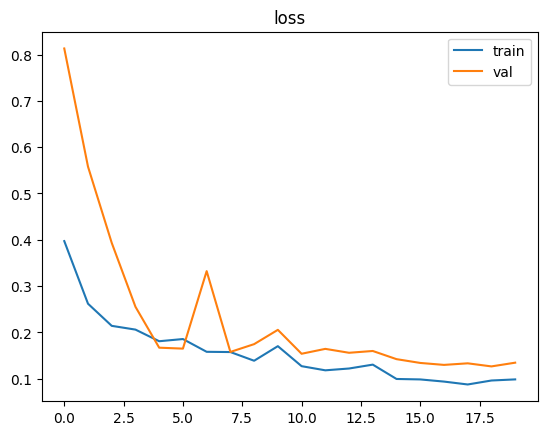

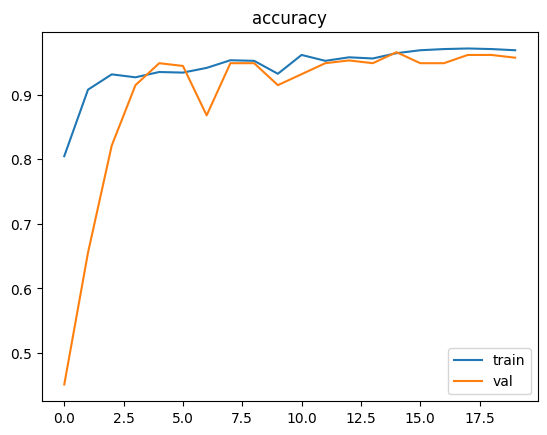

In [11]:
import matplotlib.pyplot as plt

model.load_state_dict(torch.load(best_path, map_location=device))

tr_loss, tr_acc = run_epoch(train_dl, False)
va_loss, va_acc = run_epoch(val_dl, False)
te_loss, te_acc = run_epoch(test_dl, False)

print(f"train loss {tr_loss:.4f} acc {tr_acc:.4f}")
print(f"val   loss {va_loss:.4f} acc {va_acc:.4f}")
print(f"test  loss {te_loss:.4f} acc {te_acc:.4f}")

print("gap train-val acc:", round(tr_acc - va_acc, 4))
print("gap train-test acc:", round(tr_acc - te_acc, 4))

plt.figure()
plt.plot(hist["tr_loss"], label="train")
plt.plot(hist["va_loss"], label="val")
plt.legend()
plt.title("loss")
plt.show()

plt.figure()
plt.plot(hist["tr_acc"], label="train")
plt.plot(hist["va_acc"], label="val")
plt.legend()
plt.title("accuracy")
plt.show()

Переобучение нет, тк train/val accuracy близки, разница train–test близка к 0. Кривые train/val loss убывают без роста val loss на поздних эпохах

In [12]:
from torch.utils.data import DataLoader

model.load_state_dict(torch.load(best_path, map_location=device))
model.eval()

all_ds = BinImgDS(files_np.tolist(), y.tolist(), eval_tfm)
all_dl = DataLoader(all_ds, batch_size=64, shuffle=False, num_workers=0)

last_fc = None
for m in model.modules():
    if isinstance(m, torch.nn.Linear):
        last_fc = m

buf = []
def hook(module, inp, out):
    buf.append(inp[0].detach().cpu())

h = last_fc.register_forward_hook(hook)

ys = []
with torch.no_grad():
    for xb, yb in all_dl:
        xb = xb.to(device)
        model(xb)
        ys.append(yb.cpu())

h.remove()

emb = torch.cat(buf).numpy()
labels = torch.cat(ys).numpy().astype(int)

print(emb.shape, labels.shape)

(1569, 256) (1569,)


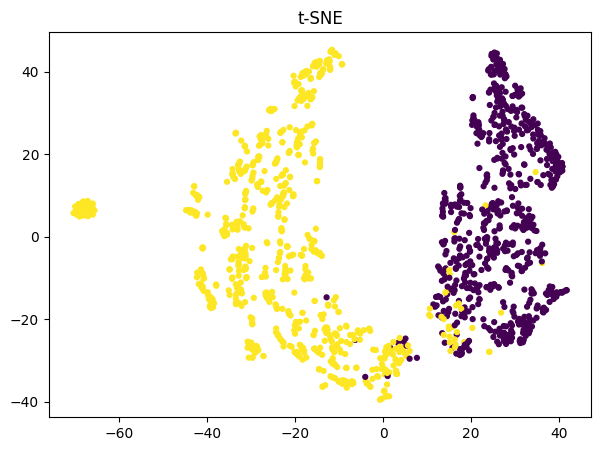

In [13]:
from sklearn.manifold import TSNE

n = len(emb)
m = 1500

if n > m:
    idx = np.random.choice(n, m, replace=False)
    X = emb[idx]
    c = labels[idx]
else:
    X = emb
    c = labels

z = TSNE(n_components=2, perplexity=30, init="pca", learning_rate="auto", random_state=42).fit_transform(X)

plt.figure(figsize=(7, 5))
plt.scatter(z[:, 0], z[:, 1], c=c, s=12)
plt.title("t-SNE")
plt.show()

Раз два класса в почти разделяются, значит предпоследний слой выучил представление, которое отделяет персонажей от остальных. Смешивание в центре это часть not_character по стилю может быть похожа на персонажей (спрайты, гуманоидные мобы, элементы интерфейса, оружие с силуэтом и т.п.).
То есть модель ошибается в основном на “похожих” примерах, а не случайно. Отдельный кусочек внизу означает подкласс внутри одного из классов, те модель понимает структуру данных, это cool


Визуально подтверждает test accuracy = 0.98 и малое количество ошибок

In [14]:
from torchvision import transforms

img_size = 224

train_tfm2 = transforms.Compose([
    transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.15, 0.15, 0.15),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225)),
])

eval_tfm2 = transforms.Compose([
    transforms.Resize(img_size + 32),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225)),
])

train_ds2 = BinImgDS(files_np[train_idx].tolist(), y[train_idx].tolist(), train_tfm2)
val_ds2   = BinImgDS(files_np[val_idx].tolist(),   y[val_idx].tolist(),   eval_tfm2)
test_ds2  = BinImgDS(files_np[test_idx].tolist(),  y[test_idx].tolist(),  eval_tfm2)

batch_size = 64
train_dl2 = DataLoader(train_ds2, batch_size=batch_size, shuffle=True,  num_workers=0)
val_dl2   = DataLoader(val_ds2,   batch_size=batch_size, shuffle=False, num_workers=0)
test_dl2  = DataLoader(test_ds2,  batch_size=batch_size, shuffle=False, num_workers=0)

In [15]:
import os, certifi
from torchvision.models import resnet18, ResNet18_Weights

os.environ["SSL_CERT_FILE"] = certifi.where()

device = "cuda" if torch.cuda.is_available() else "cpu"

model2 = resnet18(weights=ResNet18_Weights.DEFAULT)

for p in model2.parameters():
    p.requires_grad = False

in_f = model2.fc.in_features
model2.fc = nn.Sequential(
    nn.Linear(in_f, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 1),
)

model2 = model2.to(device)

crit2 = nn.BCEWithLogitsLoss()
opt2 = torch.optim.AdamW(model2.fc.parameters(), lr=1e-3, weight_decay=1e-3)
sch2 = torch.optim.lr_scheduler.ReduceLROnPlateau(opt2, mode="min", patience=2, factor=0.5)

In [16]:
@torch.no_grad()
def acc2(logits, yb):
    p = (torch.sigmoid(logits) >= 0.5).float()
    return (p == yb).float().mean().item()

def run_epoch2(dl, train):
    model2.train() if train else model2.eval()

    loss_sum, acc_sum, n = 0.0, 0.0, 0

    for xb, yb in dl:
        xb = xb.to(device)
        yb = yb.to(device)

        if train:
            opt2.zero_grad(set_to_none=True)

        logits = model2(xb).squeeze(1)
        loss = crit2(logits, yb)

        if train:
            loss.backward()
            nn.utils.clip_grad_norm_(model2.fc.parameters(), 1.0)
            opt2.step()

        bs = xb.size(0)
        loss_sum += loss.item() * bs
        acc_sum += acc2(logits, yb) * bs
        n += bs

    return loss_sum / n, acc_sum / n

run_name2 = datetime.now().strftime("tl_%Y%m%d_%H%M%S")
w2 = SummaryWriter(f"runs/{run_name2}")

hist2 = {"tr_loss": [], "va_loss": [], "tr_acc": [], "va_acc": []}

best_val = 1e9
bad = 0
patience = 5
best_path2 = f"best_{run_name2}.pt"

epochs = 15

for ep in range(1, epochs + 1):
    tr_loss, tr_acc = run_epoch2(train_dl2, True)
    va_loss, va_acc = run_epoch2(val_dl2, False)

    sch2.step(va_loss)

    hist2["tr_loss"].append(tr_loss)
    hist2["va_loss"].append(va_loss)
    hist2["tr_acc"].append(tr_acc)
    hist2["va_acc"].append(va_acc)

    w2.add_scalar("loss/train", tr_loss, ep)
    w2.add_scalar("loss/val",   va_loss, ep)
    w2.add_scalar("acc/train",  tr_acc,  ep)
    w2.add_scalar("acc/val",    va_acc,  ep)

    print(f"ep {ep:02d} | tr {tr_loss:.4f}/{tr_acc:.4f} | va {va_loss:.4f}/{va_acc:.4f}")

    if va_loss < best_val - 1e-4:
        best_val = va_loss
        bad = 0
        torch.save(model2.state_dict(), best_path2)
    else:
        bad += 1
        if bad >= patience:
            print("early stop")
            break

w2.close()
print("run:", f"runs/{run_name2}")
print("best:", best_path2)

ep 01 | tr 0.3266/0.8569 | va 0.2386/0.9149
ep 02 | tr 0.1452/0.9380 | va 0.0931/0.9617
ep 03 | tr 0.1063/0.9672 | va 0.0808/0.9787
ep 04 | tr 0.0949/0.9663 | va 0.0724/0.9745
ep 05 | tr 0.0712/0.9736 | va 0.0908/0.9702
ep 06 | tr 0.0695/0.9736 | va 0.0650/0.9745
ep 07 | tr 0.0451/0.9845 | va 0.0773/0.9830
ep 08 | tr 0.0395/0.9872 | va 0.0749/0.9830
ep 09 | tr 0.0392/0.9900 | va 0.0698/0.9787
ep 10 | tr 0.0306/0.9881 | va 0.0708/0.9787
ep 11 | tr 0.0346/0.9854 | va 0.0697/0.9830
early stop
run: runs/tl_20260102_222715
best: best_tl_20260102_222715.pt


train: 0.0345 0.9872
val:   0.065 0.9745
test:  0.074 0.9662
gap tr-val acc: 0.0128
gap tr-test acc: 0.021


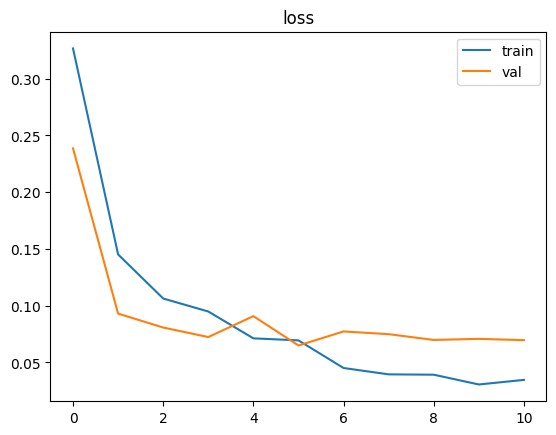

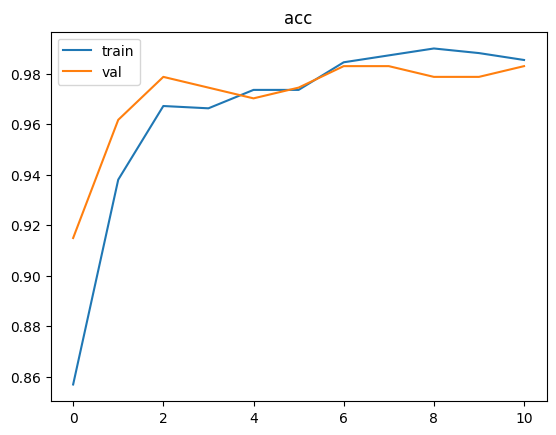

In [17]:
model2.load_state_dict(torch.load(best_path2, map_location=device))

tr_loss, tr_acc = run_epoch2(train_dl2, False)
va_loss, va_acc = run_epoch2(val_dl2, False)
te_loss, te_acc = run_epoch2(test_dl2, False)

print("train:", round(tr_loss, 4), round(tr_acc, 4))
print("val:  ", round(va_loss, 4), round(va_acc, 4))
print("test: ", round(te_loss, 4), round(te_acc, 4))

print("gap tr-val acc:", round(tr_acc - va_acc, 4))
print("gap tr-test acc:", round(tr_acc - te_acc, 4))

plt.figure()
plt.plot(hist2["tr_loss"], label="train")
plt.plot(hist2["va_loss"], label="val")
plt.legend()
plt.title("loss")
plt.show()

plt.figure()
plt.plot(hist2["tr_acc"], label="train")
plt.plot(hist2["va_acc"], label="val")
plt.legend()
plt.title("acc")
plt.show()

Между train и test около 0.011, что говорит об отсутствии переобучения. По графикам loss/accuracy валидация не деградирует на поздних эпохах. Все ок!

In [18]:
import time

def seed_all(s=42):
    np.random.seed(s)
    torch.manual_seed(s)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(s)

@torch.no_grad()
def acc1(logits, yb):
    p = (torch.sigmoid(logits) >= 0.5).float()
    return (p == yb).float().mean().item()

def run_epoch_any(model, dl, device, crit, opt=None, max_batches=None):
    train = opt is not None
    model.train() if train else model.eval()

    loss_sum, acc_sum, n = 0.0, 0.0, 0

    for i, (xb, yb) in enumerate(dl):
        if max_batches is not None and i >= max_batches:
            break

        xb = xb.to(device)
        yb = yb.to(device)

        if train:
            opt.zero_grad(set_to_none=True)

        logits = model(xb).view(-1)
        loss = crit(logits, yb)

        if train:
            loss.backward()
            opt.step()

        bs = xb.size(0)
        loss_sum += loss.item() * bs
        acc_sum += acc1(logits, yb) * bs
        n += bs

    return loss_sum / max(n, 1), acc_sum / max(n, 1)

@torch.no_grad()
def eval3(model, device, crit, dl_tr, dl_va, dl_te):
    tr = run_epoch_any(model, dl_tr, device, crit)
    va = run_epoch_any(model, dl_va, device, crit)
    te = run_epoch_any(model, dl_te, device, crit)
    return tr, va, te

In [19]:
def train_cnn_timed(epochs=10, patience=3, max_batches=40, seed=42):
    seed_all(seed)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    m = CNN().to(device)
    crit = nn.BCEWithLogitsLoss()
    opt = torch.optim.AdamW(m.parameters(), lr=3e-4, weight_decay=1e-3)
    sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", patience=1, factor=0.5)

    best = 1e9
    bad = 0
    best_state = None

    t0 = time.perf_counter()
    for ep in range(1, epochs + 1):
        tr_loss, tr_acc = run_epoch_any(m, train_dl, device, crit, opt=opt, max_batches=max_batches)
        va_loss, va_acc = run_epoch_any(m, val_dl,   device, crit, max_batches=max_batches)

        sch.step(va_loss)
        print("cnn", ep, round(tr_loss,4), round(tr_acc,4), "|", round(va_loss,4), round(va_acc,4))

        if va_loss < best - 1e-4:
            best = va_loss
            bad = 0
            best_state = {k: v.detach().cpu().clone() for k, v in m.state_dict().items()}
        else:
            bad += 1
            if bad >= patience:
                break
    t1 = time.perf_counter()

    if best_state is not None:
        m.load_state_dict(best_state)

    tr = run_epoch_any(m, train_dl, device, crit, max_batches=max_batches)
    va = run_epoch_any(m, val_dl,   device, crit, max_batches=max_batches)
    te = run_epoch_any(m, test_dl,  device, crit, max_batches=max_batches)

    return {
        "model": "CNN",
        "epochs": ep,
        "time_sec": t1 - t0,
        "train_loss": tr[0], "train_acc": tr[1],
        "val_loss": va[0],   "val_acc": va[1],
        "test_loss": te[0],  "test_acc": te[1],
    }

r1 = train_cnn_timed()
r1

cnn 1 0.3999 0.8286 | 1.2438 0.4511
cnn 2 0.27 0.8961 | 0.7156 0.5532
cnn 3 0.2146 0.9325 | 0.1747 0.9404
cnn 4 0.1997 0.9271 | 0.1946 0.9277
cnn 5 0.1833 0.9362 | 0.2416 0.9234
cnn 6 0.1798 0.9389 | 0.1705 0.9319
cnn 7 0.1793 0.9389 | 0.1635 0.9362
cnn 8 0.1604 0.9453 | 0.1841 0.9277
cnn 9 0.1514 0.949 | 0.1927 0.9362
cnn 10 0.1425 0.9562 | 0.1652 0.9362


{'model': 'CNN',
 'epochs': 10,
 'time_sec': 65.00077695801156,
 'train_loss': 0.14771380721707722,
 'train_acc': 0.9480401094979118,
 'val_loss': 0.16345116619734054,
 'val_acc': 0.9361702107368631,
 'test_loss': 0.14478950105010205,
 'test_acc': 0.9451476795763909}

In [20]:
def train_tl_timed(epochs=8, patience=3, max_batches=40, seed=42):
    seed_all(seed)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    m = resnet18(weights=ResNet18_Weights.DEFAULT)
    for p in m.parameters():
        p.requires_grad = False

    in_f = m.fc.in_features
    m.fc = nn.Sequential(
        nn.Linear(in_f, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, 1),
    )
    m = m.to(device)

    crit = nn.BCEWithLogitsLoss()
    opt = torch.optim.AdamW(m.fc.parameters(), lr=1e-3, weight_decay=1e-3)
    sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", patience=1, factor=0.5)

    best = 1e9
    bad = 0
    best_state = None

    t0 = time.perf_counter()
    for ep in range(1, epochs + 1):
        tr_loss, tr_acc = run_epoch_any(m, train_dl2, device, crit, opt=opt, max_batches=max_batches)
        va_loss, va_acc = run_epoch_any(m, val_dl2,   device, crit, max_batches=max_batches)

        sch.step(va_loss)
        print("tl ", ep, round(tr_loss,4), round(tr_acc,4), "|", round(va_loss,4), round(va_acc,4))

        if va_loss < best - 1e-4:
            best = va_loss
            bad = 0
            best_state = {k: v.detach().cpu().clone() for k, v in m.state_dict().items()}
        else:
            bad += 1
            if bad >= patience:
                break
    t1 = time.perf_counter()

    if best_state is not None:
        m.load_state_dict(best_state)

    tr = run_epoch_any(m, train_dl2, device, crit, max_batches=max_batches)
    va = run_epoch_any(m, val_dl2,   device, crit, max_batches=max_batches)
    te = run_epoch_any(m, test_dl2,  device, crit, max_batches=max_batches)

    return {
        "model": "ResNet18 TL",
        "epochs": ep,
        "time_sec": t1 - t0,
        "train_loss": tr[0], "train_acc": tr[1],
        "val_loss": va[0],   "val_acc": va[1],
        "test_loss": te[0],  "test_acc": te[1],
    }

r2 = train_tl_timed()
r2

tl  1 0.2852 0.876 | 0.1498 0.9362
tl  2 0.1503 0.9417 | 0.0906 0.9702
tl  3 0.087 0.9745 | 0.0798 0.966
tl  4 0.071 0.9763 | 0.0753 0.9702
tl  5 0.0759 0.9754 | 0.0968 0.966
tl  6 0.0722 0.9781 | 0.072 0.966
tl  7 0.0499 0.9818 | 0.0658 0.966
tl  8 0.0518 0.9827 | 0.0648 0.9745


{'model': 'ResNet18 TL',
 'epochs': 8,
 'time_sec': 164.6313649159856,
 'train_loss': 0.03476041433831835,
 'train_acc': 0.9854147675478578,
 'val_loss': 0.0648282748429065,
 'val_acc': 0.9744680851063829,
 'test_loss': 0.0630909702917443,
 'test_acc': 0.9789029538379943}

In [21]:
import pandas as pd

df = pd.DataFrame([r1, r2])
df["time_min"] = df["time_sec"] / 60
df = df[["model","epochs","time_min","train_acc","val_acc","test_acc","train_loss","val_loss","test_loss"]]
df

,model,epochs,time_min,train_acc,val_acc,test_acc,train_loss,val_loss,test_loss
0,CNN,10,1.083346,0.948040,0.936170,0.945148,0.147714,0.163451,0.144790
1,ResNet18 TL,8,2.743856,0.985415,0.974468,0.978903,0.034760,0.064828,0.063091


Для сравнения замерим время обучения и качество моделей на одинаковом окружении. CNN обучалась быстрее, но показала более низкое качество. Transfer learning на ResNet18 занял больше времени из-за более тяжёлого backbone и входа 224×224, зато дал более высокое качество. Таким образом, TL оказался вычислительно дороже, но эффективнее по метрикам на тестовой выборке.  
Сравнение времени сделано при одинаковом batch_size и одинаковом ограничении числа батчей на эпоху (ускоренный прогон)